In [1]:
import sys
sys.path.append('..')

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader

from models.basic_axial.basic_axialnet import BasicAxial, AxialUNetMed
from models.basic_axial.basic_axial_parts import BlockAxialDown, BlockAxial, BlockAxialUp, conv1x1
from datasets.ice import Ice, IceWithProposals
from metrics.segmentation import _fast_hist, per_class_pixel_accuracy, jaccard_index
from metrics.utils import display_metric_list

import matplotlib.pyplot as plt

import os

In [2]:
data_dir = '../data'
img_scale = .35
img_crop = 220

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_set = Ice(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
                  os.path.join(data_dir, 'txt_files'), 'test', img_scale, img_crop)
test_loader = DataLoader(test_set, batch_size=1)

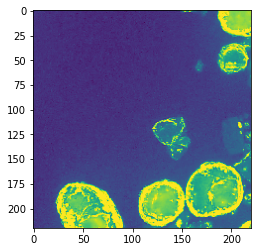

In [3]:
batch = test_set[0]
img = batch['image'].unsqueeze(0)
plt.imshow(img.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);

In [4]:
net = AxialUNetMed(3, 3, 10)

In [5]:
out = net(img)

x1:  torch.Size([1, 10, 220, 220])
x2:  torch.Size([1, 20, 110, 110])
x3:  torch.Size([1, 40, 55, 55])
x4:  torch.Size([1, 20, 110, 110])
x5:  torch.Size([1, 10, 220, 220])
logits:  torch.Size([1, 3, 220, 220])


In [4]:
encode = BlockAxial(3, 10, img_shape=(img_crop, img_crop))
decode = conv1x1(10, 3)
down = BlockAxialDown(10, 20, img_shape=(img_crop, img_crop))
up = BlockAxialUp(20, 10, img_shape=(img_crop//2, img_crop//2))

In [5]:
x1 = encode(img)
print(x1.shape)
x2 = down(x1)
print(x2.shape)
x3 = up(x2, x1)
print(x3.shape)
logits = decode(x3)
print(logits.shape)

torch.Size([1, 10, 220, 220])
torch.Size([1, 20, 110, 110])
torch.Size([1, 10, 220, 220])
torch.Size([1, 3, 220, 220])


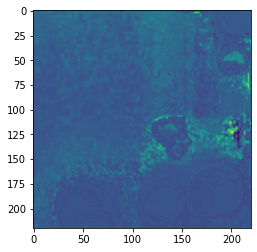

In [8]:
plt.imshow(logits.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,2]);

In [9]:
up = BlockAxialUp(20, 10, img_shape=(img_crop//2, img_crop//2))

In [10]:
final = up(x2, x1)

torch.Size([1, 20, 220, 220])
torch.Size([1, 50, 220, 220])


In [12]:
print(final.shape)

torch.Size([1, 10, 220, 220])


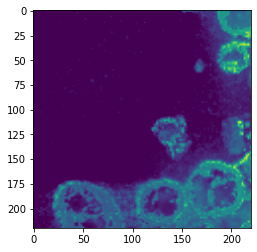

In [20]:
plt.imshow(final.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,7]);